# PER with Sparse Pauli-Lindblad Model
In quantum simulation algorithms, the result at the end of the algorithm is usually not a single binary value, but instead the expectation value of some operator, which is approximated by averaging over many shots of the same circuit. In the presence of noisy operations, the estimator for such an expectation value is biased, which affects the quality of the result.

The purpose of this notebook is to illustrate a procedure for mitigating this bias and increasing the accuracy of the estimators of the expectation values. 

The first step is performing a tomography experiment to learn the noise model. A process called "Pauli twirling" can be used to convert the noise into a Pauli channel. 

The noise is then assumed to be generated by a master equation with quantum jump operators proportional to Pauli operators. The noise channel can then be expressed as $\Lambda(\rho) = e^{-\mathcal L (\rho)}$, where

$$
\hat{\mathcal L} = \sum_{k}\lambda_k (\hat P_k - \hat I)
$$

This master equation will be referred to as a "sparse Pauli-Lindblad," model. The word sparse indicates that only Pauli operators which have support on physically connected qubits are considered in the model. 

Once the $\lambda_k$ are learned, a partially inverted noise channel can be constructed:

$$
\hat \Lambda^{(\xi)} = \gamma^{(\xi)}\prod_{k}\omega^{(\xi)}_k \hat I+\text{sgn}(1-\xi)(1-\omega_k^{(\xi)}\hat P_k)
$$
Where we have defined $\omega^{(\xi)}_k = \frac{1}{2}(1+e^{-2|\xi-1|\lambda_k})$ and
$$
\gamma^{(\xi)}
= \begin{cases}
\exp(2\sum_k (1-\xi)\lambda_k) & \xi < 1 \\
1 & \xi \geq 1
\end{cases}
$$
This channel can be implemented by sampling from it probabilistically and rescaling the results by the overhead $\gamma^{(\xi)}$. It can be shown that as $\xi \to 0$, 
$$
\hat \Lambda^{(\xi)} \to \hat \Lambda^{-1}
$$
the notation has been overloaded slightly, and $\Lambda^{-1}$ is used to indicate the inverse of $\Lambda$. In addition, as $\xi \to \infty, we have $\Lambda^{(\xi)} \to P_{max}$, where $P_{max}(\rho) = I$ for all $\rho$. Because of this, measurements at different values of $\xi$ can be used to extrapolate to the zero-noise limit with an appropriate fit.

The scope of this notebook is to demonstrate the tools presented here for learning $\lambda_k$ on a simulated noisy backend, and then carrying out PER to approximate a relevant expectation value on a desired circuit.

In [36]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from matplotlib import pyplot as plt
import sys
import numpy as np

sys.path.append("../../pauli_lindblad_per/")
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [20, 6]

In [37]:
backend = FakeVigoV2()

In [38]:
qc = QuantumCircuit(2)
qc.rz(np.pi/2,0)
qc.sx(0)
qc.rz(3*np.pi/4,0)

qc.rz(np.pi/2,1)
qc.sx(1)
qc.rz(np.pi/2,1)

qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.rz(np.pi/4,0)
qc.cx(0,1)
qc.draw()

┌─────────┐┌────┐┌──────────┐     ┌─────────┐     ┌─────────┐     »
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(3π/4) ├──■──┤ Rz(π/4) ├──■──┤ Rz(π/4) ├──■──»
     ├─────────┤├────┤├─────────┬┘┌─┴─┐└─────────┘┌─┴─┐└─────────┘┌─┴─┐»
q_1: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ X ├───────────┤ X ├───────────┤ X ├»
     └─────────┘└────┘└─────────┘ └───┘           └───┘           └───┘»
«     ┌─────────┐     
«q_0: ┤ Rz(π/4) ├──■──
«     └─────────┘┌─┴─┐
«q_1: ───────────┤ X ├
«                └───┘

In [39]:

def executor(circuits):
    return backend.run(circuits, shots = 500).result().get_counts()

In [40]:
experiment = tomography(circuits = [qc], inst_map = [0,1], backend = backend)

In [41]:
experiment.generate(samples = 32, single_samples = 100, depths = [2,4,16])

In [42]:
experiment.run(executor)

In [43]:
noisedataframe = experiment.analyze()

In [44]:
perexp = experiment.create_per_experiment([qc])

In [45]:
perexp.generate(expectations = ["IX", "XI"], samples = 1000, noise_strengths = [0,1,2])

## Run!

In [46]:
perexp.run(executor)

In [47]:
circuit_results = perexp.analyze()

In [48]:
perexp.get_overhead(0,0)

1.187281287118085

<AxesSubplot:>

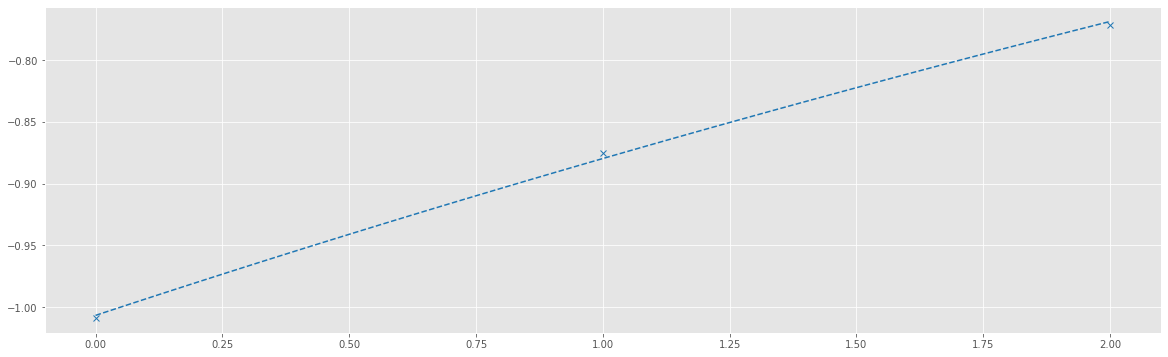

In [49]:
circuit_results[0].get_result("IX").plot()

In [50]:
layer1 = experiment.analysis.get_layer_data(0)

<AxesSubplot:>

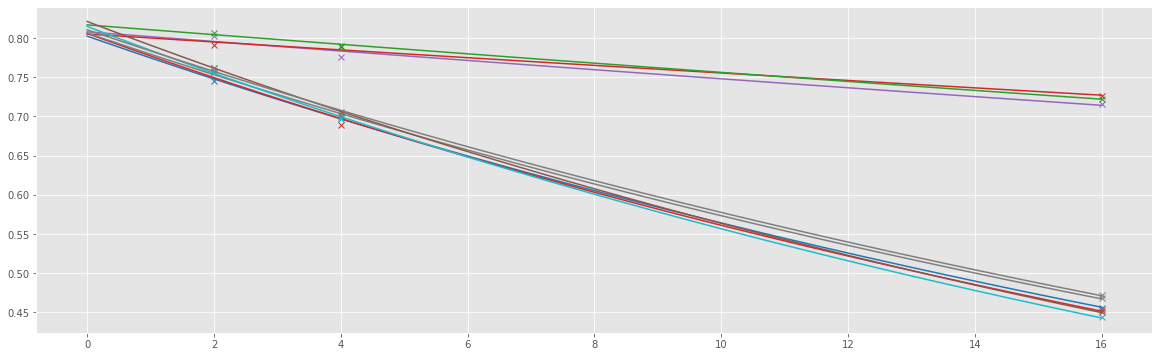

In [51]:
layer1.graph((0,1))

<AxesSubplot:>

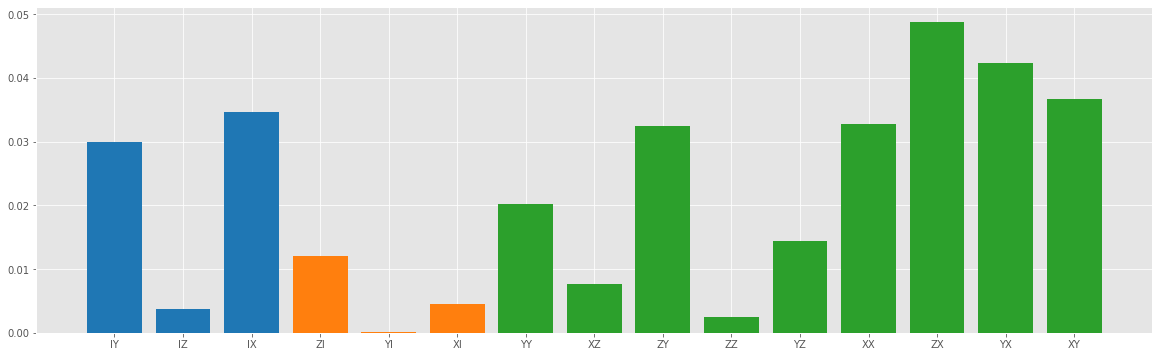

In [52]:
layer1.plot_infidelitites((0,),(1,),(0,1))